### uncomment and run the following cell if you are on Google Colab

In [ ]:
# !pip install git+https://github.com/vafaei-ar/drama.git

In [37]:
import drama as drm
from drama.v1.outlier_finder import grid_run_drama,D_Drama
import numpy as np
import pylab as plt
from matplotlib import gridspec
from sklearn.metrics import roc_auc_score
%matplotlib inline

### Loading MNIST data

(60000, 784) (60000,)


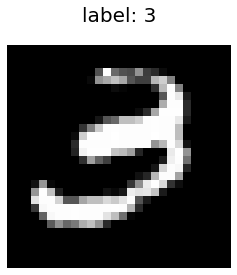

In [2]:
try:
    import tensorflow as tf
    (x,y),_ = tf.keras.datasets.mnist.load_data(path="mnist.npz")
    x = x.reshape(60000,-1)
except:
    from sklearn.datasets import load_digits
    digits = load_digits()
    x = digits.data
    y = digits.target

ll = int(np.sqrt(x.shape[1]))
ii = np.random.randint(np.shape(y))[0]
plt.matshow(x[ii].reshape(ll,ll),cmap='gray')
plt.axis('off')
plt.title('label: '+str(y[ii]),fontsize=20)
print(x.shape,y.shape)

### Preparing anomaly dataset

In [100]:
out_filter = (y==0)
in_filter = (y==1)|(y==2)
print(in_filter.sum(),out_filter.sum())

12700 5923


In [101]:
n_anomaly = 200
n_inlier = 2000
x_obs = np.concatenate([x[y==2][:n_anomaly],
                        x[y==1][:n_inlier],
                        x[y==0][:n_inlier]])
labels = np.concatenate([y[y==2][:n_anomaly],
                        y[y==1][:n_inlier],
                        y[y==0][:n_inlier]])
inds = np.arange(labels.shape[0])
np.random.shuffle(inds)
x_obs = x_obs[inds]
x_obs = x_obs/x_obs.max()
labels = labels[inds]
y_ano = labels==2
print(x_obs.shape,labels.shape)

(4200, 784) (4200,)


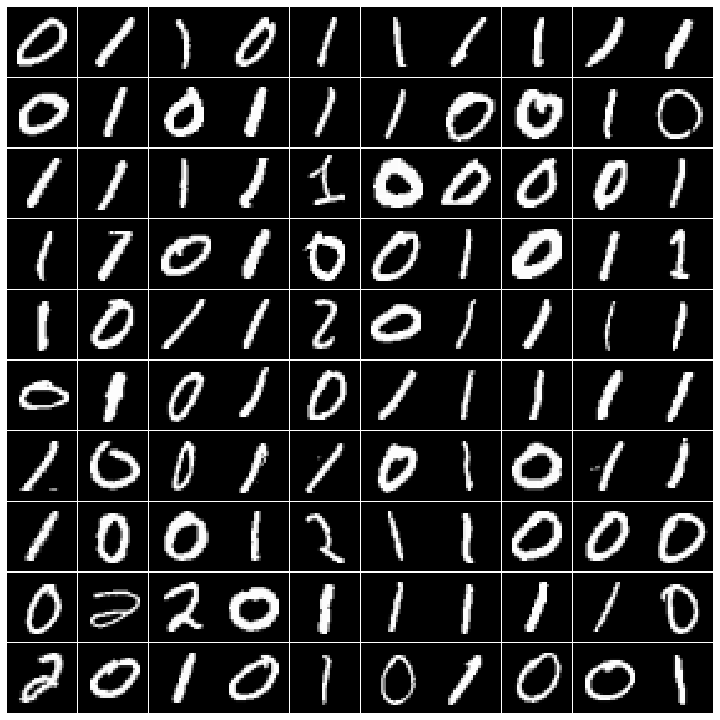

In [106]:
lside = 10
ll = int(np.sqrt(x_obs.shape[1]))

fig,axis = plt.subplots(lside,lside,figsize=(10,10))
for i in range(lside):
    for j in range(lside):
        ii = np.random.randint(np.shape(y_ano))[0]
        axis[i,j].matshow(x_obs[ii].reshape(ll,ll),cmap='gray')
        axis[i,j].axis('off')
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.02, hspace=0.02)
plt.savefig('mnist.jpg',dpi=150)  

### Anomaly detection

In [5]:
n_split = 1
drama = D_Drama(x_obs,drt_name='VAE',z_dim=2)
drama.fit(x_obs,n_split=n_split,space='real')
y_pred = drama.predict(x_obs,metrics='braycurtis')

In [39]:
roc_auc_score(y_ano.astype(int),y_pred/y_pred.max())

0.88935875

In [110]:
anomalies.shape

(100, 784)

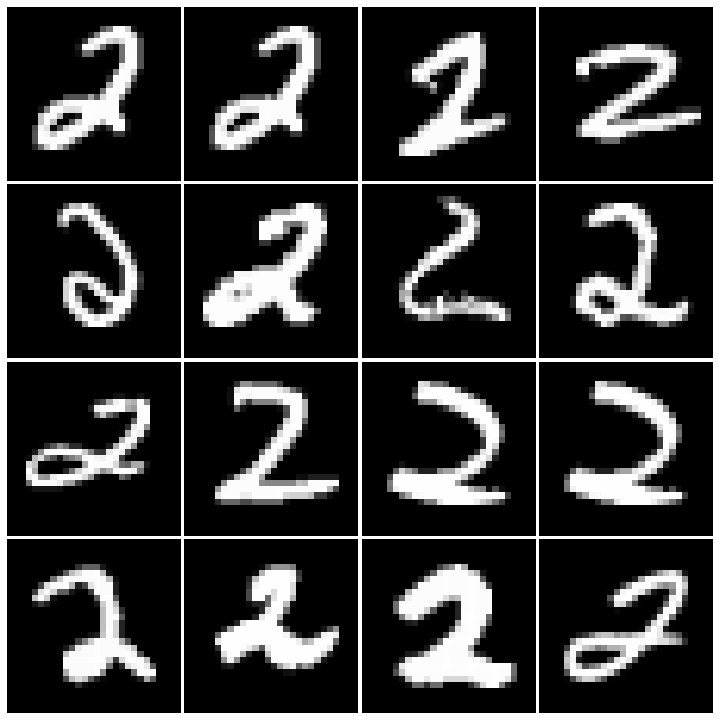

In [114]:
anomalies = x_obs[np.argsort(y_ano)[::-1][:100]]

lside = 4
ll = int(np.sqrt(anomalies.shape[1]))

fig,axis = plt.subplots(lside,lside,figsize=(10,10))
for i in range(lside):
    for j in range(lside):
        ii = np.random.randint(100)
        axis[i,j].matshow(anomalies[ii].reshape(ll,ll),cmap='gray')
        axis[i,j].axis('off')
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.02, hspace=0.02)
plt.savefig('anomalies.jpg',dpi=150)  

In [7]:
# if you like to see the average of more tries: 
# rws = []
# for _ in range(5):svd
#     drama = D_Drama(x_obs,drt_name='VAE',z_dim=2)
#     drama.fit(x_obs,n_split=1,space='real')
#     y_pred = drama.predict(x_obs,metrics='chebyshev')
#     rws.append(rws_score(y_obs,y_pred))
# print(np.mean(rws),np.std(rws))

### You can also see how the subclusters are distributed

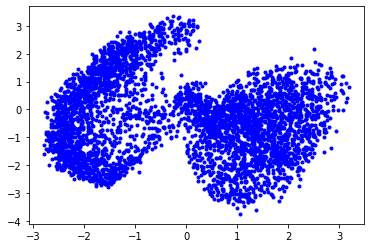

In [8]:
points = drama.splitter.z_mu[n_split-1]
points.shape
plt.plot(points[:,0],points[:,1],'b.')

In [93]:
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

def background(ax,X_red,ll,h=.02):
    X_train, y_train = X_red,ll
    x_min, x_max = 0,1.1
    y_min, y_max = 0,1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    clf = SVC(gamma=10, C=1000)
    clf.fit(X_train, y_train)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    cm = plt.cm.RdBu
    Z = Z.reshape(xx.shape)
    cnt = ax.contourf(xx, yy, Z, np.linspace(Z.min(),Z.max(),100),linestyles=None, cmap=cm, alpha=.6)
    # This is the fix for the white lines between contour levels
    for c in cnt.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.00000000000001)
    
def plot_clustering(ax, X_red, labels, y_ano, n_sample=200, fontsize=20, title=None): 
    colors = ['r','b','g']
    for i in np.random.randint(0,X_red.shape[0],n_sample):
        ax.text(X_red[i, 0], X_red[i, 1], str(labels[i]),
                 color=colors[y_ano[i]],
                 fontdict={'weight': 'bold', 'size': fontsize})

    ax.set_xticks([])
    ax.set_yticks([])
#     ax.tight_layout(rect=[0, 0.03, 1, 0.95])

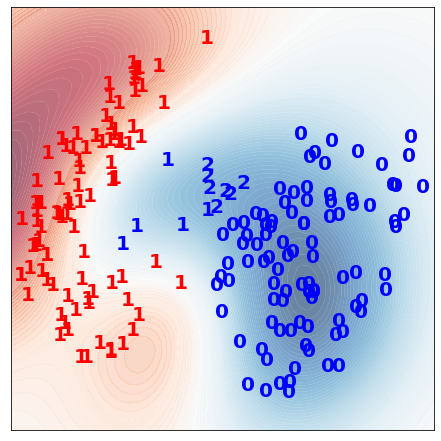

In [94]:
ll = drama.splitter.labels[0].astype(int) #labels
X_red = drama.splitter.z_mu[n_split-1]

x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
X_red = (X_red - x_min) / (x_max - x_min)

fig,ax = plt.subplots(1,1,figsize=(6, 6))
background(ax,X_red,ll)
plot_clustering(ax, X_red, labels, ll)

ax.set_xlim(0,1)
ax.set_ylim(0,1.05)

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.02)
plt.savefig('zspace.jpg',dpi=150)

### And see what DRAMA considered as the protypes

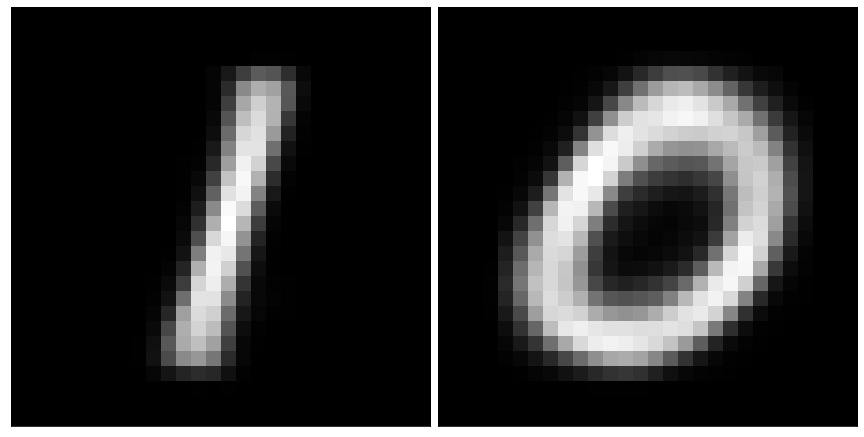

In [115]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.imshow(drama.splitter.mean_components[0][0,0].reshape(28,28),cmap='gray')
ax2.imshow(drama.splitter.mean_components[0][0,1].reshape(28,28),cmap='gray')

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.02)
plt.savefig('mains.jpg',dpi=150)

### It is also possible to survey on different configurations

Unsupervised outlier detection mode.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Unsupervised outlier detection mode.
Unsupervised outlier detection mode.


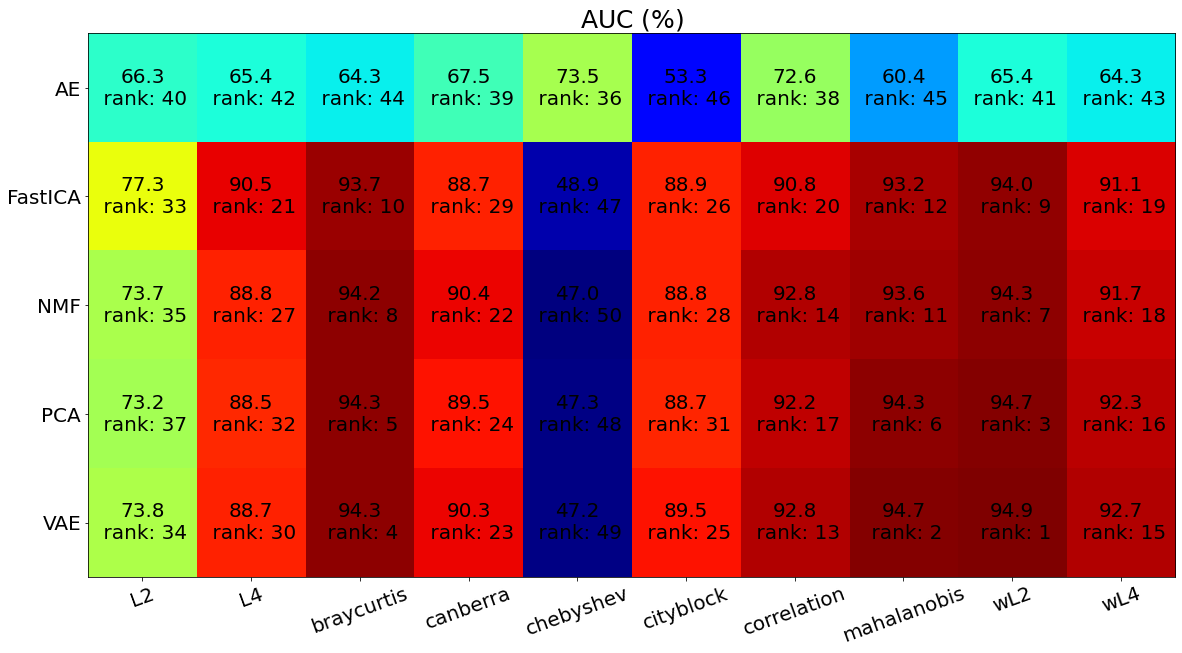

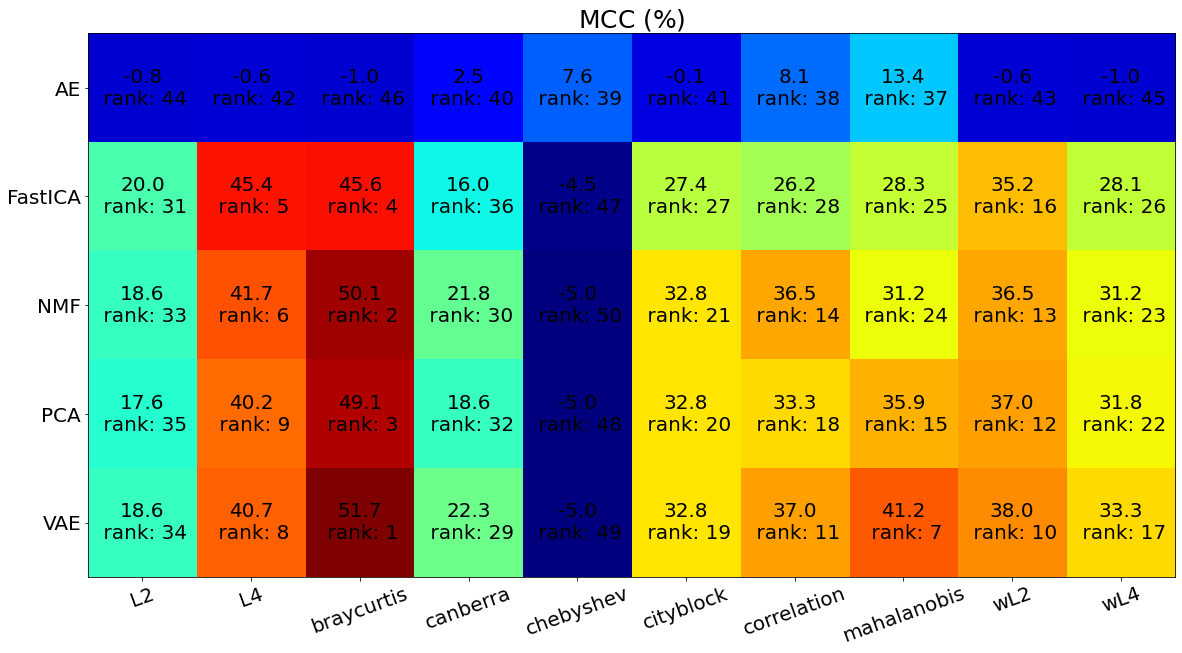

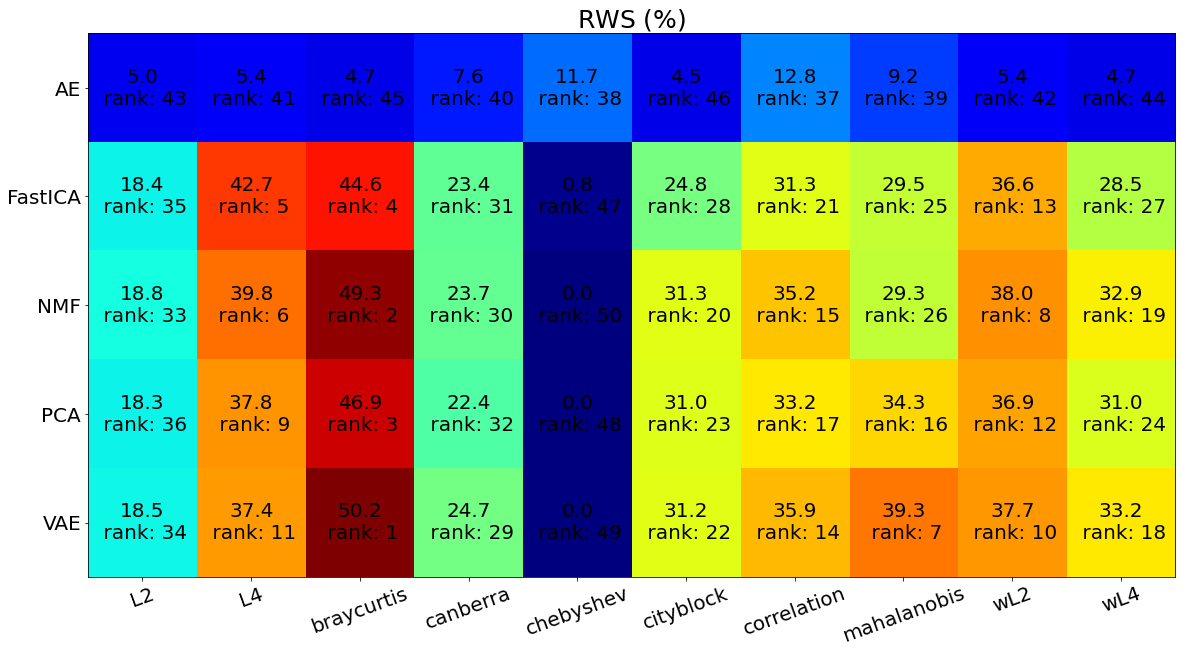

In [96]:
n_try = 3

result = []
for i in range(n_try):
    auc,mcc,rws,conf = grid_run_drama(X_seen=x_obs,y_seen=y_ano)
    arr = np.stack([auc,mcc,rws],axis=-1)
    result.append(arr)
result = np.array(result)

drts = np.unique(conf[:,1])
metrs = np.unique(conf[:,2])

res = result.reshape(n_try,5,10,-1)
drm.plot_table(np.mean(res,axis=0),drts,metrs)